# Tutorial on speeding up running python code on a high performance computing cluster

* Machine learning jobs can take a long time to run
* How can your code exploit the number of cores

There are a number of motivations for running machine learning  or AI jobs in parallel on a computer cluster.
When a python script is run on a worker node on the cluster, by default, it runs on only one core. Some of the nodes on the cluster have 16 cores. If the script could use all 16 cores then potentially the script could run 16 times faster. In practice the speedup is less than the number of cores. Larger data sets may not fit into the memory of a single node, so if the python script can run on multiple nodes larger data sets could be used in the analysis.

In this tutorial we will look at some basic tools to use more of the cores on the cluster with an emphasis on data science and AI applications. Most applications will be Embarrassingly parallel (https://en.wikipedia.org/wiki/Embarrassingly_parallel) where there is little communication between the python running on different cores until the jobs end and the results are collected. 

## Background on parallel computer.

A high performance computer is made of compute nodes connected by a network. Each compute node has a number of cores.

<img src="https://github.com/cmcneile/HPC-tutorial/blob/main/A-modern-NUMA-system-with-four-nodes-and-eight-cores-per-node.png?raw=true"/>

There are different ways of running programs on parallel computers made from nodes connected by a network
* **Threads**
* **Processes**
* **MPI** Message Passing Interface
* **shared-memory parallel programming**



## Running the examples on the cluster

This file is a jupyter notebook that you can download to your own machine.
I suggest you paste the python code into a text file to run on the cluster 

This basic tutorial was created by Craig McNeile  https://www.plymouth.ac.uk/staff/craig-mcneile by modifying examples from other sources.

### Philosophy 

As the python is run on more cores then the time taken should decrease. To test this the code should be run with a different number of cores and the execution time should be measured. The code below shows how to time how long a function takes to run.


In [11]:
import math
from time import time
 
# define a cpu-intensive task
def task(arg):https://www.researchgate.net/publication/323058591/figure/fig1/AS:622777811890177@1525493209635/A-modern-NUMA-system-with-four-nodes-and-eight-cores-per-node.png
    return sum([math.sqrt(i) for i in range(1, arg)])
 

# report a message
print('Starting task...')
start = time()
# perform calculations
results = task(5000000)
time_taken = time() - start
print(f"Time taken to run the function {time_taken:.2f} s")


Starting task...
Time taken to run the function 0.43 s


In [13]:
import timeit
import_module = "import math"
testcode = ''' 
def task(): 
    return sum([math.sqrt(i) for i in range(1,5000000 )])
'''
print(timeit.repeat(stmt=testcode, setup=import_module))


[0.0554012659995351, 0.05171712700393982, 0.05300903299939819, 0.04790831301943399, 0.04787989699980244]


It is useful to plot the time taken for some code to run with on the number of cores. The python code below can do this. You should run it on your own computer.

A code that has good performance on a cluster should take time that decreases linearly with the number of cores. The time to run many codes don't such behaviour as the number of cores is increased. 

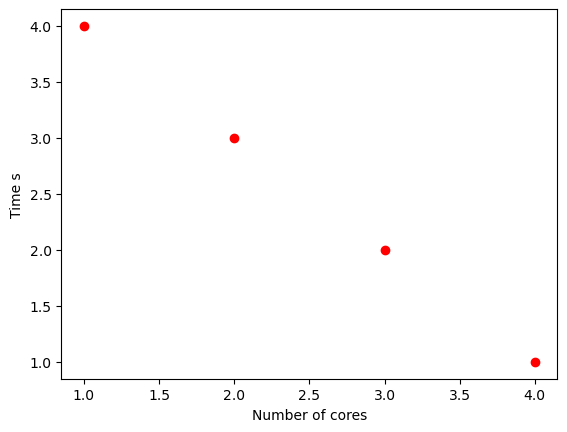

In [3]:
import numpy as np
import matplotlib.pyplot as plt

no_cores       = [  1, 2 , 3 , 4  ] 
time_taken     =  [ 4 , 3 , 2 , 1 ] 

plt.plot(no_cores, time_taken, "ro")
plt.xlabel('Number of cores')
plt.ylabel('Time s')
plt.show()

### Tip

If you want an explanation of what some of the python code is doing you can write
**Explain the python code** and paste the code into ChatGPT https://chat.openai.com/
See this example below

<img src="https://github.com/cmcneile/HPC-tutorial/blob/main/ChatGPt.png?raw=true" alt="ChatGPT example" />


## Plan of the tutorial

* Running machine learning algorithms in the python scikit-learn module on multiple cores
* Using the numba library (https://numba.pydata.org/) to run code on multiple cores.
* Running python on multiple processes that run on multiple cores.
* Under development: an introduction to dask.

The numba and dask libraries will work with multiple cores and GPUs.

##  Using multiple cores to run machine learning jobs

*  Example 1 and 2 were developed from this page  https://machinelearningmastery.com/multi-core-machine-learning-in-python/
*  See the reference material on scikit learn about running paralllel jobs https://scikit-learn.org/stable/computing/parallelism.html

Sometimes the hard work of making an application run on multiple cores has been done by the team that wrote the application. The user just has to input the number of cores to use. Sometimes there are other options that can change the speed of the code. 

In [1]:
from time import time
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

* We create a fake data set that the classifier can be run on.
* The data set is then split into a test (20%) and training (80%) data set.

In [5]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=20, n_informative=15, n_redundant=5, random_state=3)
print("Shape of X = ", X.shape)
print("Shape of y = " , y.shape)
print("First elements of y = ", y[0:10])

# break the dataset into test and train data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Shape of X =  (10000, 20)
Shape of y =  (10000,)
First elements of y =  [0 0 0 1 1 1 0 0 0 1]


We create a classifier using the random forest method (https://www.ibm.com/topics/random-forest)

In [6]:
number_of_cores = 1
# define the model
model = RandomForestClassifier(n_estimators=500, n_jobs=number_of_cores)
# record current time
start = time()
# fit the model
model.fit(X_train, y_train)
# record current time
end = time()
# report execution time

# evaluate the model on the test data set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("The confusion matrix")
print(cm)

result = end - start
print('Time taken %.3f seconds' % result, "with ", number_of_cores, "cores")



Accuracy: 0.956
The confusion matrix
[[933  56]
 [ 32 979]]
Time taken 13.008 seconds with  1 cores


### Questions

* Try running the above code with number_of_cores = 1,2,4,8,16,32 and record the timings. How does the time taken change?
* Is the model.predict function call run on multiple cores?

### Example 2

An important part of the machine learning is tuning the hyperparamters to obtain good performance of the algorithm.
The hyperparameters can be looped over a grid of the different possibilities or random points can be selected in a region of the space of hyperparameters.


In [20]:
%reset -f
from time import time
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint



In [21]:
# create the dataset again
X, y = make_classification(n_samples=10000, n_features=20, n_informative=15, n_redundant=5, random_state=3)

# break the dataset into test and train data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
modelA = RandomForestClassifier()

njob = 4
# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(modelA, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5, n_jobs=njob)

# Fit the random search object to the data

print("Starting the random search")

start = time()
rand_search.fit(X_train, y_train)
end = time()

result = end - start
print("No cores = ", njob , 'Time taken %.3f seconds' % result)




Starting the random search


/home/cmcneile/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/cmcneile/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/cmcneile/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/cmcneile/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"

No cores =  4 Time taken 26.115 seconds


In [23]:
# evaluate the model
y_pred = rand_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

##ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print(cm)


Accuracy: 0.9475
[[911  74]
 [ 31 984]]


### Questions

*  Try running the above code with number_of_cores = 1,2,4,8,16,32 . How does the time taken change?

### Example 3 

* Some python code can be speeded by using libraries
* One such library is https://numba.pydata.org/
* Numba has options to run code in parallel

The use of **@jit(parallel = True)** are function decorators https://www.datacamp.com/tutorial/decorators-python

In [8]:
from time import time
from numba import jit
import numpy as np

x = np.arange(100).reshape(10, 10)

#@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit

@jit(parallel = True)
def go_fast(a): # Function is compiled to machine code when called the first time
    trace = 0.0
    for i in range(a.shape[0]):   # Numba likes loops
        trace += np.tanh(a[i, i]) # Numba likes NumPy functions
    return a + trace              # Numba likes NumPy broadcasting

start = time()
print(go_fast(x))
end = time()

result = end - start
print('Time taken %.3f seconds' % result)

start = time()
ans = go_fast(x)
end = time()
print('Time taken %.3f seconds' % result)

[[  9.  10.  11.  12.  13.  14.  15.  16.  17.  18.]
 [ 19.  20.  21.  22.  23.  24.  25.  26.  27.  28.]
 [ 29.  30.  31.  32.  33.  34.  35.  36.  37.  38.]
 [ 39.  40.  41.  42.  43.  44.  45.  46.  47.  48.]
 [ 49.  50.  51.  52.  53.  54.  55.  56.  57.  58.]
 [ 59.  60.  61.  62.  63.  64.  65.  66.  67.  68.]
 [ 69.  70.  71.  72.  73.  74.  75.  76.  77.  78.]
 [ 79.  80.  81.  82.  83.  84.  85.  86.  87.  88.]
 [ 89.  90.  91.  92.  93.  94.  95.  96.  97.  98.]
 [ 99. 100. 101. 102. 103. 104. 105. 106. 107. 108.]]
Time taken 0.001 seconds
Time taken 0.001 seconds


### Example 4 

*  We can use  concurrent.futures module (https://docs.python.org/3/library/concurrent.futures.html#module-concurrent.futures) to run functions over multiple cores.
*  This example is based on this page: https://superfastpython.com/python-use-all-cpu-cores/

In the example below the **task** function is run on multiple cores. 

The task function computes the sum of the square root of each integer in a list

$$
task = \sum_{i=1}^{i=arg}  \sqrt{i}
$$

In your own application you would modify the function **task**

In [1]:
# SuperFastPython.com
# example of a program that does not use all cpu cores
import math
from time import time
 
# define a cpu-intensive task
def task(arg):
    return sum([math.sqrt(i) for i in range(1, arg)])
 

# report a message
print('Starting task...')
start = time()
# perform calculations
results = [task(i) for i in range(1,50000)]
end = time()

result = end - start
print('Time taken %.3f seconds' % result)

Starting task...
Time taken 86.125 seconds


In [5]:
number_of_cores = 2
# create the process pool
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor

start = time()
with  ProcessPoolExecutor(number_of_cores) as exe:
    # perform calculations
    results = exe.map(task, range(1,50000))

end = time()

result = end - start
print('Time taken %.3f seconds' % result, "on " , number_of_cores , "cores")

Time taken 33.307 seconds on  4 cores


### Questions

*  Try running the above code with number_of_cores = 1,2,4,8,16,32 . How does the time taken change?
*  Repeat the timing measurements with the function **ThreadPoolExecutor**
*  What is the difference between threads and processes

## Introduction to dask

Dask solves the common problem “Help me scale my notebook onto the cluster”.

* Dask is a general purpose parallel programming solution.
* Dask is a wrapper over the common python librarie NumPy, Pandas, Jupyter, Scikit-Learn that allows them to run on computing clusters
* Dask has a dataframe (similar to pandas) that can run over multiple cores and nodes
* Dask has an array that can run over multiple cores and nodes.
* Dask can run different functions on  multiple cores and nodes.

The main web page for Dask is https://docs.dask.org/en/stable/

The general structure of dask is:

![Structure of dask](https://docs.dask.org/en/stable/_images/dask-overview.svg)


### Example 5



In [1]:
import dask_ml.datasets
import dask_ml.cluster
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'dask_ml'

## Example 6 

This example is taken from https://examples.dask.org/applications/embarrassingly-parallel.html#Use-Dask-Delayed-to-make-our-function-lazy


In [21]:
import time
from time import time
import random
import math

def task(arg):
    return sum([math.sqrt(i) for i in range(1, arg)])

Now run the same application using dask

In [22]:
from dask.distributed import Client, progress
client = Client(threads_per_worker=4, n_workers=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 4,Total memory: 15.31 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42253,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 15.31 GiB
Comm: tcp://127.0.0.1:37481,Total threads: 4
Dashboard: http://127.0.0.1:43705/status,Memory: 15.31 GiB
Nanny: tcp://127.0.0.1:44961,


In [23]:
print('Starting task...')
start = time()
# perform calculations
results = [task(i) for i in range(1,50000)]
time_taken = time() - start
print(f"Time taken for scalar python = {time_taken:.2f} s"  )

Starting task...
Time taken for scalar python = 92.93 s


In [26]:
import dask
lazy_results = []

In [27]:
for i in range(1,50000):
    lazy_result = dask.delayed(task)(i)
    lazy_results.append(lazy_result)

In [28]:
print('Starting dask task...')
start = time()
dask.compute(*lazy_results)
time_taken = time() - start
print(f"Time taken for dask = {time_taken:.2f} s"  )

Starting dask task...
Time taken for dask = 154.44 s


In [20]:
#client.close()


In [29]:
client.cluster.scale(10)  # ask for ten 4-thread workers
print('Starting dask task...')
start = time()
dask.compute(*lazy_results)
time_taken = time() - start
print(f"Time taken for dask = {time_taken:.2f} s"  )



Starting dask task...
Time taken for dask = 71.00 s
